In [1]:
import numpy as np 
print(np.__version__)

2.3.4


In [2]:
# =============================================================
# Cardiovascular Disease Prediction
# Dataset: cardio_train.csv
# =============================================================


import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
import joblib

# Optional XGBoost
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False


In [14]:

df = pd.read_csv("cardio_train(1).csv",sep=';')  
df.head()


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [15]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
df.columns = [c.strip().lower() for c in df.columns]


if df['age'].median() > 100:
    df['age_years'] = (df['age'] / 365).round().astype(int)
else:
    df['age_years'] = df['age']

# Fix invalid blood pressures
df = df[(df['ap_hi'] > 30) & (df['ap_hi'] < 300)]
df = df[(df['ap_lo'] > 20) & (df['ap_lo'] < 200)]
swap_mask = df['ap_lo'] > df['ap_hi']
df.loc[swap_mask, ['ap_hi', 'ap_lo']] = df.loc[swap_mask, ['ap_lo', 'ap_hi']].values

# Reasonable height & weight
df = df[(df['height'] > 100) & (df['height'] < 230)]
df = df[(df['weight'] > 20) & (df['weight'] < 300)]

# Ensure binary columns are ints
for col in ['smoke', 'alco', 'active', 'cardio']:
    df[col] = df[col].astype(int)

# Clip cholesterol/glucose values to valid range
df['cholesterol'] = df['cholesterol'].clip(1, 3)
df['gluc'] = df['gluc'].clip(1, 3)

# Add BMI feature
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
df.head()


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52,23.507805
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48,23.011177


Cardiovascular disease distribution:
cardio
0    0.505076
1    0.494924
Name: proportion, dtype: float64


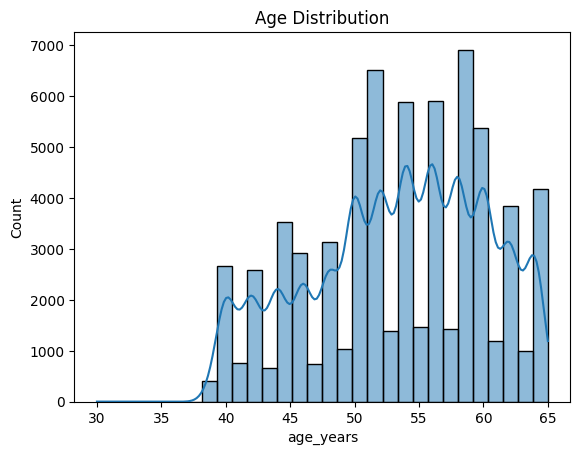

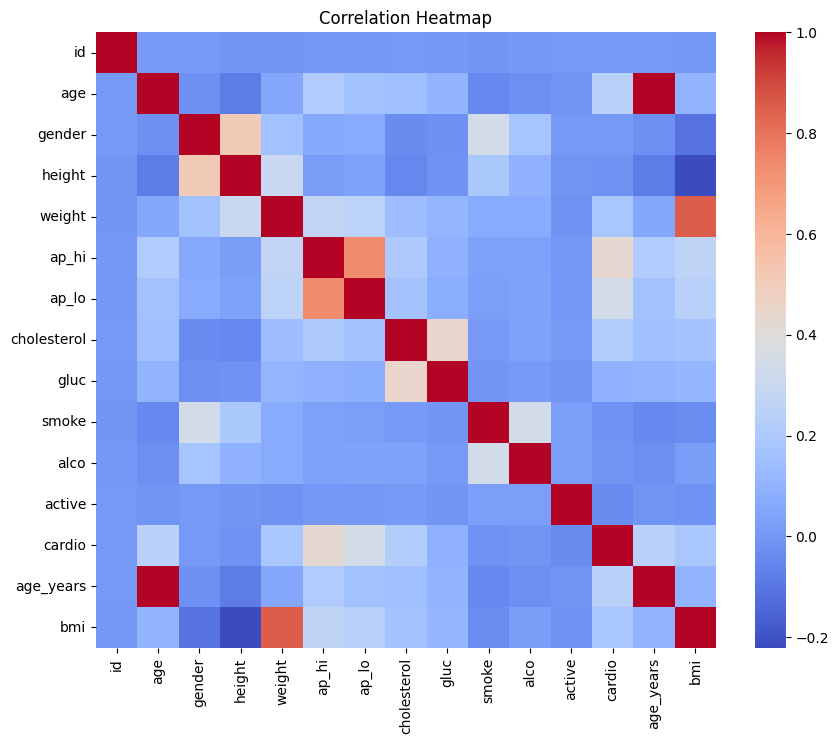

In [17]:
print("Cardiovascular disease distribution:")
print(df['cardio'].value_counts(normalize=True))

# Age distribution
sns.histplot(df['age_years'], bins=30, kde=True)
plt.title("Age Distribution")
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()


In [18]:
X = df.copy()
y = X.pop('cardio')

# Drop unnecessary columns if any
if 'id' in X.columns:
    X = X.drop(columns=['id'])
if 'age' in X.columns:
    X = X.drop(columns=['age'])

numeric = ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi']
categorical = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric),
        ('cat', categorical_transformer, categorical)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [19]:
models = {}

# Logistic Regression
pipe_lr = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])
pipe_lr.fit(X_train, y_train)
models['Logistic Regression'] = pipe_lr

# Random Forest
pipe_rf = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
])
pipe_rf.fit(X_train, y_train)
models['Random Forest'] = pipe_rf

# XGBoost (optional)
if XGBOOST_AVAILABLE:
    pipe_xgb = Pipeline(steps=[
        ('pre', preprocessor),
        ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
    ])
    pipe_xgb.fit(X_train, y_train)
    models['XGBoost'] = pipe_xgb



Logistic Regression Results:
Accuracy: 0.725 | Precision: 0.754 | Recall: 0.661 | F1: 0.704 | ROC-AUC: 0.789
              precision    recall  f1-score   support

           0       0.70      0.79      0.74      6945
           1       0.75      0.66      0.70      6805

    accuracy                           0.73     13750
   macro avg       0.73      0.72      0.72     13750
weighted avg       0.73      0.73      0.72     13750



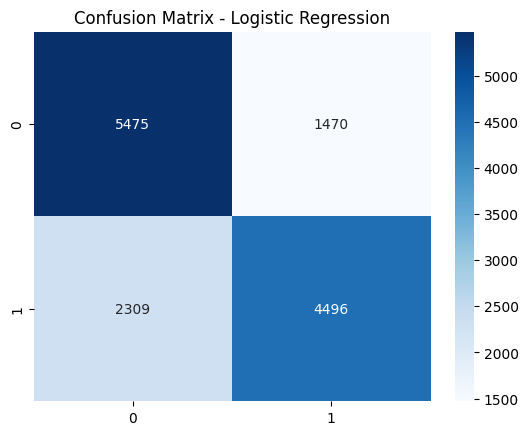

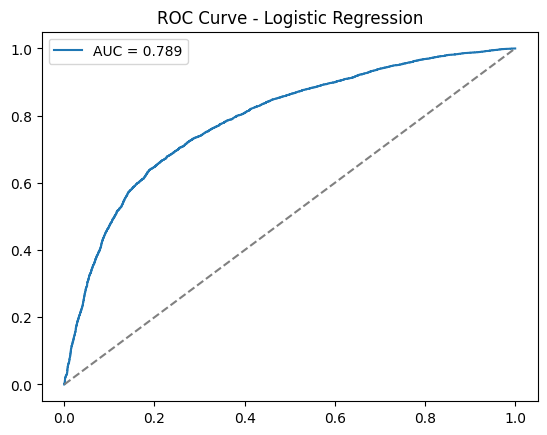


Random Forest Results:
Accuracy: 0.706 | Precision: 0.708 | Recall: 0.689 | F1: 0.699 | ROC-AUC: 0.760
              precision    recall  f1-score   support

           0       0.70      0.72      0.71      6945
           1       0.71      0.69      0.70      6805

    accuracy                           0.71     13750
   macro avg       0.71      0.71      0.71     13750
weighted avg       0.71      0.71      0.71     13750



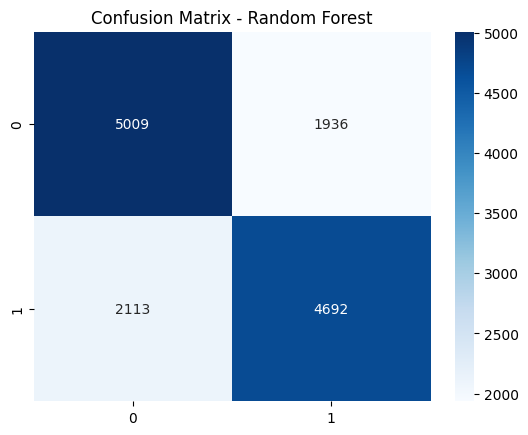

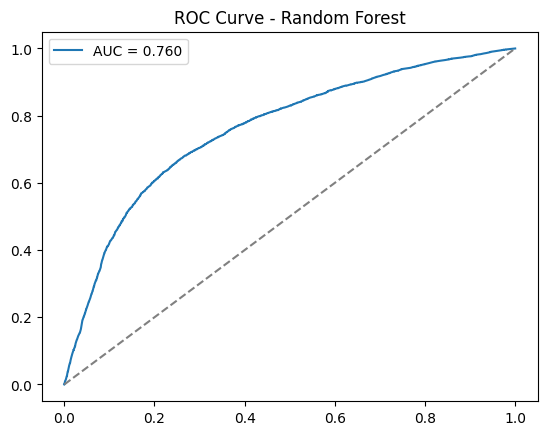

In [20]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)

    print(f"\n{name} Results:")
    print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f} | ROC-AUC: {roc:.3f}")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"AUC = {roc:.3f}")
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.legend()
    plt.title(f"ROC Curve - {name}")
    plt.show()

for name, model in models.items():
    evaluate_model(model, X_test, y_test, name)


In [21]:
rf_pipe = models['Random Forest']

print("Performing Cross-Validation...")
cv_scores = cross_val_score(rf_pipe, X, y, cv=5, scoring='roc_auc')
print("Mean ROC-AUC:", cv_scores.mean())

param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5]
}

grid = GridSearchCV(rf_pipe, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)
print("Best ROC-AUC Score:", grid.best_score_)


Performing Cross-Validation...
Mean ROC-AUC: 0.7656464095905642
Best Parameters: {'clf__max_depth': 10, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Best ROC-AUC Score: 0.800016837465043


In [22]:
best_model = grid.best_estimator_
joblib.dump(best_model, "best_model.joblib")
print("✅ Best model saved as best_model.joblib")


✅ Best model saved as best_model.joblib


In [23]:
# Example: Predict risk for a new person
sample = pd.DataFrame([{
    'age_years': 55,
    'height': 170,
    'weight': 80,
    'ap_hi': 130,
    'ap_lo': 85,
    'bmi': 80 / (1.7 ** 2),
    'gender': 2,
    'cholesterol': 3,
    'gluc': 2,
    'smoke': 0,
    'alco': 0,
    'active': 1
}])

pred = best_model.predict(sample)[0]
print("Predicted: Person has cardiovascular disease" if pred == 1 else "Predicted: Person is healthy")


Predicted: Person has cardiovascular disease
